# Cats and Dogs

Este notebook implementa um experimento de **transferência de conhecimento** (*"transfer learning"*)

## Código de suporte

### Módulos utilizados

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython import display

import os
import time
import glob
import sys
import copy
import pickle
import numpy as np
import numpy.random as nr
from PIL import Image
import scipy.ndimage

from collections import OrderedDict

from torch.utils.data import DataLoader, Dataset
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
from torch.optim.lr_scheduler import MultiStepLR, StepLR
from torch.autograd import Variable

import torchvision
from torchvision import datasets, transforms, models

import lib.pytorch_trainer as ptt

use_gpu = torch.cuda.is_available()
print('GPU available:', use_gpu)

GPU available: False


## Dataset

In [2]:
class PetsDataset(Dataset):
    
    def __init__(self, data_dir, transforms=None, is_validation=False, is_test=False,
                 use_only=1.0, validation_split=0.1, random_seed=20170929):        
        self.transforms = transforms
        if is_test:
            self.classes = ['unknown']
            self.pets = []
            self.is_dog = []
            pet_count = len(glob.glob(data_dir + '/*.jpg'))
            for index in range(1, pet_count + 1):
                path = os.path.join(data_dir, '{}.jpg'.format(index))
                self.pets.append(path)
                self.is_dog.append(0)
        else:
            nr.seed(random_seed)
            pets = nr.permutation(glob.glob(data_dir + '/*.jpg'))
            length = pets.shape[0]
            only = int(use_only * length)
            pets = pets[:only]
            length = pets.shape[0]
            vlen = int(validation_split * length)
            if is_validation:
                self.pets = pets[:vlen]
            else:
                self.pets = pets[vlen:]
            self.is_dog = np.array([os.path.basename(fn).startswith('dog') for fn in self.pets], np.int)
            self.classes = ['cat', 'dog']

    def __len__(self):
        return len(self.pets)
    
    def __getitem__(self, index):
        path = self.pets[index]
        label = self.is_dog[index]
        with open(path, 'rb') as f:
            with Image.open(f) as img:
                image = img.convert('RGB')                
        if self.transforms is not None:
            image = self.transforms(image)
        return image, label
    

In [3]:
data_path = '/data/datasets/CatsDogs_kaggle/train'
test_path = '/data/datasets/CatsDogs_kaggle/test1'
batch_size = 50
img_width, img_height = 224, 224

def my_transforms(img, img_width=img_width, img_height=img_height):
    return img.resize((img_width, img_height))

imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std  = np.array([0.229, 0.224, 0.225])

def denormalize(image, mean=imagenet_mean, std=imagenet_std):
    inp = image.transpose((1, 2, 0))
    img = std * inp + mean
    return img

### Data augmentation and normalization for training 

In [4]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.Lambda(my_transforms),
        transforms.ToTensor(),
        transforms.Normalize(imagenet_mean, imagenet_std),
    ]),
    'valid': transforms.Compose([
        transforms.Lambda(my_transforms),
        transforms.ToTensor(),
        transforms.Normalize(imagenet_mean, imagenet_std),
    ]),
}

dsets = {
    'train': PetsDataset(data_path, transforms=data_transforms['train'], validation_split=0.2),
    'valid': PetsDataset(data_path, transforms=data_transforms['valid'], is_validation=True, validation_split=0.2),
    'test':  PetsDataset(test_path, transforms=data_transforms['valid'], is_test=True),
}

dset_loaders = {
    'train': DataLoader(dsets['train'], batch_size=batch_size, shuffle=True,  pin_memory=use_gpu),
    'valid': DataLoader(dsets['valid'], batch_size=batch_size, shuffle=False, pin_memory=use_gpu),
    'test':  DataLoader(dsets['test'],  batch_size=batch_size, shuffle=False, pin_memory=use_gpu),
}

dset_sizes = {x: len(dsets[x]) for x in ['train', 'valid', 'test']}
dset_classes = dsets['train'].classes
dset_classes, dset_sizes

(['cat', 'dog'], {'test': 12500, 'train': 20000, 'valid': 5000})

### Visualizando algumas amostras

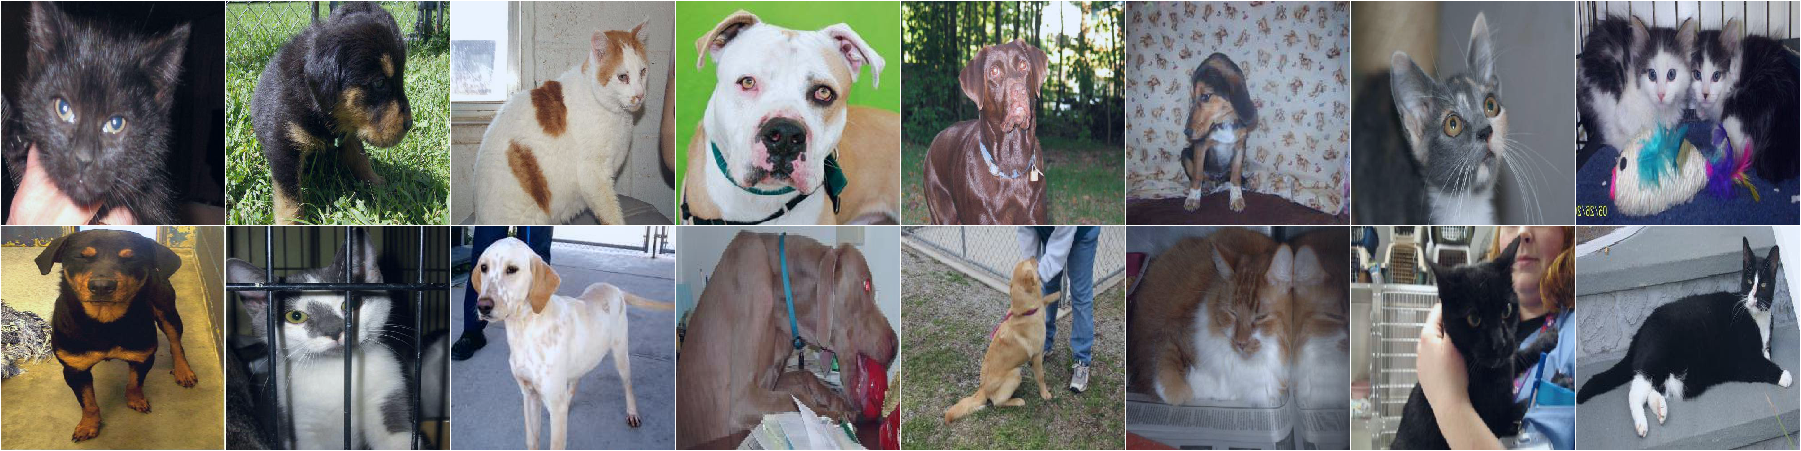

In [5]:
tensor2pil = transforms.ToPILImage()
# pega um batch de imagens
image_batch, labels = next(iter(dset_loaders['train']))

# cria um grid com as imagens
grid = torchvision.utils.make_grid(image_batch[:16], normalize=True, pad_value=1.0, padding=1)
img_pil = tensor2pil(grid)
img_pil

## Modelo

Modelo Resnet34 com parâmetros pré treinados.

In [6]:
class MyResNet(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.resnet = models.resnet34(pretrained=True)    
        for param in self.resnet.parameters():
            param.requires_grad = False
            
        n_feat = self.resnet.fc.in_features
        fc_old = self.resnet.fc.state_dict()            
        fc_new = dict(weight=fc_old['weight'][(284, 208), :], bias=fc_old['bias'][(284, 208),])

        self.resnet.fc = nn.Linear(n_feat, 2)
        self.resnet.fc.load_state_dict(fc_new)

    def forward(self, input_):
        return self.resnet.forward(input_)

model = MyResNet()
if use_gpu:
    model = model.cuda()

## Treinamento

In [7]:
finetuning = False
if finetuning:
    for param in model.resnet.layer4.parameters():
        param.requires_grad = True
    optimizer = optim.Adam([{'params': model.resnet.layer4.parameters(), 'lr': 1e-6}, 
                            {'params': model.resnet.fc.parameters(),     'lr': 1e-5}])
    scheduler = StepLR(optimizer, step_size=10, gamma=0.75)
    
else:
    optimizer =  optim.Adam(model.resnet.fc.parameters(), lr=1e-3)
    scheduler = StepLR(optimizer, step_size=5, gamma=0.75)

criterion = nn.CrossEntropyLoss()
savebest = ptt.ModelCheckpoint('../../models/cats_dogs_resnet34_01',reset=True, verbose=1)

# Cria o objeto para treinar a rede
trainer = ptt.DeepNetTrainer(
                model       = model,
                criterion   = criterion, 
                optimizer   = optimizer,
                lr_scheduler   = scheduler,
                callbacks   = [ptt.AccuracyMetric(),ptt.PrintCallback(),savebest]
)

In [8]:
trainIt = False

if trainIt:
    trainer.fit_loader(100, dset_loaders['train'], dset_loaders['valid'])

else:
    trainer.load_state('/data/models/cats_dogs_resnet34_01')
    print('\nTraining disabled.\nThis model was trained for {} epochs.'.format(trainer.last_epoch))


Training disabled.
This model was trained for 36 epochs.


Resultado rodando GPU 1080:

        Start training for 100 epochs
          1:  96.0s   T: 0.14606 0.94290   V: 0.08129 0.97180 best
          2:  96.5s   T: 0.08168 0.96910   V: 0.05869 0.98060 best
          3:  96.7s   T: 0.06339 0.97620   V: 0.05007 0.98380 best
          4:  97.0s   T: 0.05574 0.97910   V: 0.04817 0.98400 best
          5:  95.1s   T: 0.04862 0.98265   V: 0.04191 0.98640 best
          6:  96.2s   T: 0.04437 0.98450   V: 0.04057 0.98660 best
          7:  95.6s   T: 0.04128 0.98505   V: 0.03849 0.98820 best
          8:  94.8s   T: 0.03945 0.98580   V: 0.03875 0.98740 
          9:  94.6s   T: 0.03744 0.98635   V: 0.03690 0.98820 best
         10:  94.4s   T: 0.03494 0.98710   V: 0.03589 0.98860 best
         11:  94.8s   T: 0.03258 0.98910   V: 0.03604 0.98800 
         12:  94.2s   T: 0.03009 0.98920   V: 0.03535 0.98860 best
         13:  94.5s   T: 0.02871 0.98955   V: 0.03368 0.99040 best
         14:  94.7s   T: 0.02826 0.98980   V: 0.03379 0.98940 
         15:  94.5s   T: 0.02684 0.99020   V: 0.03505 0.98900 
         16:  94.6s   T: 0.02614 0.99105   V: 0.03381 0.98940 
         17:  94.5s   T: 0.02489 0.99180   V: 0.03222 0.99020 best
         18:  94.4s   T: 0.02421 0.99205   V: 0.03267 0.99000 
         19:  94.6s   T: 0.02274 0.99240   V: 0.03232 0.99020 
         20:  94.4s   T: 0.02169 0.99275   V: 0.03237 0.98940 
         21:  94.5s   T: 0.02188 0.99250   V: 0.03434 0.98800 
         22:  94.7s   T: 0.01976 0.99325   V: 0.03232 0.98960 
         23:  94.6s   T: 0.01815 0.99430   V: 0.03257 0.98980 
         24:  94.6s   T: 0.01879 0.99405   V: 0.03456 0.98840 
         25:  94.6s   T: 0.01893 0.99400   V: 0.03257 0.98920 
         26:  94.5s   T: 0.01630 0.99515   V: 0.03231 0.98900 
         27:  94.7s   T: 0.01579 0.99525   V: 0.03208 0.98940 best
         28:  94.7s   T: 0.01497 0.99565   V: 0.03251 0.98940 
         29:  94.9s   T: 0.01536 0.99520   V: 0.03451 0.98820 
         30:  94.7s   T: 0.01655 0.99450   V: 0.03176 0.98920 best
         31:  94.7s   T: 0.01418 0.99570   V: 0.03274 0.98920 
         32:  94.6s   T: 0.01384 0.99595   V: 0.03235 0.98960 

In [9]:
metrics = trainer.evaluate_loader(dset_loaders['valid'],[ptt.AccuracyMetric()])
print('Model validation set accuracy after training: {:.5f}'.format(metrics['acc']))

evaluate: 99/99 ok
Model validation set accuracy after training: 0.99720


### Evolução do custo e acurácia

  Last training loss: 0.01380, accuracy: 0.99580
Last validation loss: 0.03415, accuracy: 0.98920


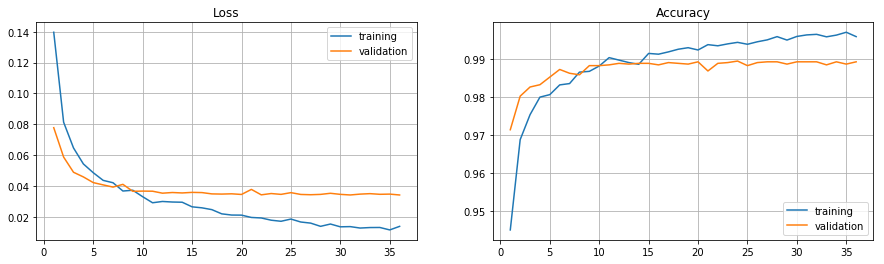

In [10]:
fig = plt.figure(figsize=(15,4))

fig.add_subplot(1, 2, 1)
plt.plot([None] + trainer.metrics['train']['losses'], label='training')
plt.plot([None] + trainer.metrics['valid']['losses'], label='validation')
plt.grid()
plt.title('Loss')
plt.legend()

fig.add_subplot(1, 2, 2)
plt.plot([None] + trainer.metrics['train']['acc'], label='training')
plt.plot([None] + trainer.metrics['valid']['acc'], label='validation')
plt.grid()
plt.title('Accuracy')
plt.legend(loc='lower right')

print('  Last training loss: {:.5f}, accuracy: {:.5f}'
      .format(trainer.metrics['train']['losses'][-1], trainer.metrics['train']['acc'][-1]))
print('Last validation loss: {:.5f}, accuracy: {:.5f}'
      .format(trainer.metrics['valid']['losses'][-1], trainer.metrics['valid']['acc'][-1]))

## Avaliação

In [11]:
y_hat_v   = trainer.predict_classes_loader(dset_loaders['valid'])
y_hat = y_hat_v.numpy()

In [12]:
y_proba_v = trainer.predict_probas_loader(dset_loaders['valid']) # prob das classes
y_prob = y_proba_v.numpy().max(axis=1) # probabilidade máxima da classe

In [13]:
x_list,y_list = [],[]
for x,y in dset_loaders['valid']:
    x_list.append(x)
    y_list.append(y)
x_test = torch.cat(x_list,dim=0)
y_test = torch.cat(y_list,dim=0)

### Matriz de confusão

In [14]:
from pandas import crosstab
crosstab(y_test, y_hat)

col_0,0,1
row_0,,
0,2506,9
1,5,2480


### Acertos de maior probabilidade

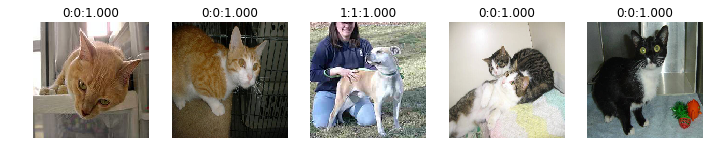

In [15]:
i_ok = np.where(y_hat==y_test)[0]
top_most_ok = np.argsort(y_prob[i_ok])[-5:][::-1]
y_top5 = i_ok[top_most_ok]
fig, raxis = plt.subplots(1,5,figsize=(12,8)) 
for k,i in enumerate(y_top5):
    raxis[k].imshow(denormalize(x_test[i].numpy()).clip(0.,1.))
    raxis[k].set_title('{}:{}:{:0.3f}'.format(y_test[i],y_hat[i],y_prob[i]))
    raxis[k].axis('off')

### Acertos de menor probabilidade

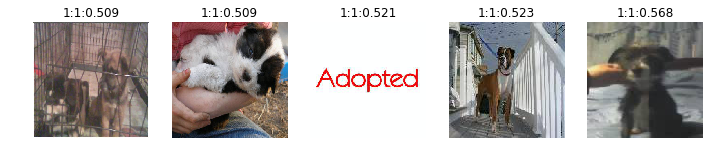

In [16]:
i_ok = np.where(y_hat==y_test)[0]
top_least_ok = np.argsort(y_prob[i_ok])[:5]
y_bot5 = i_ok[top_least_ok]
fig, raxis = plt.subplots(1,5,figsize=(12,8)) 
for k,i in enumerate(y_bot5):
    raxis[k].imshow(denormalize(x_test[i].numpy()).clip(0.,1.))
    raxis[k].set_title('{}:{}:{:0.3f}'.format(y_test[i],y_hat[i],y_prob[i]))
    raxis[k].axis('off')

### Erros de maior probabilidade

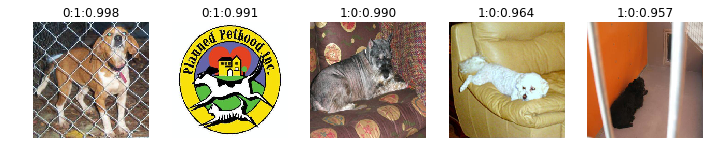

In [17]:
i_not_ok = np.where(y_hat!=y_test)[0]
top_most_not_ok = np.argsort(y_prob[i_not_ok])[-5:][::-1]
y_most_not_ok_top5 = i_not_ok[top_most_not_ok]
fig, raxis = plt.subplots(1,5,figsize=(12,8)) 
for k,i in enumerate(y_most_not_ok_top5):
    raxis[k].imshow(denormalize(x_test[i].numpy()).clip(0.,1.))
    raxis[k].set_title('{}:{}:{:0.3f}'.format(y_test[i],y_hat[i],y_prob[i]))
    raxis[k].axis('off')

### Erros de menor probabilidade

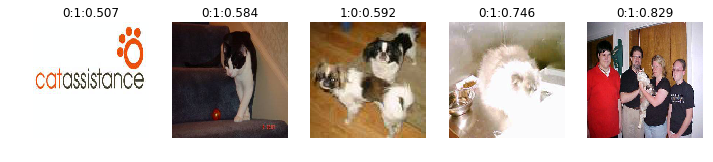

In [ ]:
i_not_ok = np.where(y_hat!=y_test)[0]
top_least_not_ok = np.argsort(y_prob[i_not_ok])[:5]
y_least_not_ok_top5 = i_not_ok[top_least_not_ok]
fig, raxis = plt.subplots(1,5,figsize=(12,8)) 
for k,i in enumerate(y_least_not_ok_top5):
    raxis[k].imshow(denormalize(x_test[i].numpy()).clip(0.,1.))
    raxis[k].set_title('{}:{}:{:0.3f}'.format(y_test[i],y_hat[i],y_prob[i]))
    raxis[k].axis('off')

## Kaggle submission

In [ ]:
def gen_kaggle_submission(data_loader=dset_loaders['test'], fn='kaggle_submission.csv'):
    preds = trainer.predict_loader(data_loader)
    probas = F.softmax(Variable(preds),dim=1).data[:, 1].cpu().numpy()
    probas = np.around(probas, decimals=3)
    probas = np.clip(probas, 0.002, 0.998)
    with open(fn, 'w') as sub:
        print('id,label', file=sub)
        for i in range(probas.shape[0]):
            print('{},{:.3f}'.format(i+1, probas[i]), file=sub)

gen_kaggle_submission()

# cats_dogs_resnet34_01: no clip,         loss = 0.06886
# cats_dogs_resnet34_01: clip: 0.9998,    loss = 0.05960
# cats_dogs_resnet34_01: clip: 0.998,     loss = 0.05264  #86
# cats_dogs_resnet34_01: clip: 0.98,      loss = 0.05951

- [kaggle_submission.csv](kaggle_submission.csv)  # 157 Public Leaderboard